In [1]:
"""
Initialization:

When loading initial conditions, pay attention to the units used. In this example, I am using the 'galaxy.txt' file to
import a 400-body toy model of a galaxy. The initial conditions in the file are written using non-SI units, in particular masses are
expressed in solar masses (2e30kg), distances in terms of a scale radius specific to the given galaxy and equal to 3.082e22 meters, and
velocities are given in 1e5m/s units.

When loading this data into the BODIES list, I convert each value into SI units to be consistent with the code.

An alternative approach would be to convert the code into new units, which would change values for things such as the gravitational
constant G and initial/final time t/T. The advantage of this approach is that python won't have to deal with extremely large numbers, 
leading to higher efficacy. However, the results won't be as intuitive to interpret as if they were given in SI units, meaning you will
probably need to convert back to SI at the end to analyze the data.

In this example, the 400-body galaxy isn't very computationally demanding, so I opted to convert everything into SI units.
"""

"\nInitialization:\n\nWhen loading initial conditions, pay attention to the units used. In this example, I am using the 'galaxy.txt' file to\nimport a 400-body toy model of a galaxy. The initial conditions in the file are written using non-SI units, in particular masses are\nexpressed in solar masses (2e30kg), distances in terms of a scale radius specific to the given galaxy and equal to 3.082e22 meters, and\nvelocities are given in 1e5m/s units.\n\nWhen loading this data into the BODIES list, I convert each value into SI units to be consistent with the code.\n\nAn alternative approach would be to convert the code into new units, which would change values for things such as the gravitational\nconstant G and initial/final time t/T. The advantage of this approach is that python won't have to deal with extremely large numbers, \nleading to higher efficacy. However, the results won't be as intuitive to interpret as if they were given in SI units, meaning you will\nprobably need to convert 

In [2]:
"""
Note: If this is your first time writing this code, I suggest you start off with a much simpler system to simulate. An excellent example is the Earth-Sun system. In this case, you won't need to bother with importing data from an outside source, or unit conversions.

A simple line such as

BODIES = [body(2e30,0,0,0,0,0,0), body(6e24,1.5e11,0,0,0,2*3.14159*1.5e11/(365*24*3600),0)]

gives you a good approximation of the starting conditions for the Earth's rotation around the Sun, with the Sun centered in the (0,0,0) point. If you simulate this for a year or two, you should expect to plot an ellipse in the X-Y plane, representing Earth's rotation around the Sun during those years.

Once this is working as intended, it's a simple upgrade to import the initial conditions from an outside database.
"""

"\nNote: If this is your first time writing this code, I suggest you start off with a much simpler system to simulate. An excellent example is the Earth-Sun system. In this case, you won't need to bother with importing data from an outside source, or unit conversions.\n\nA simple line such as\n\nBODIES = [body(2e30,0,0,0,0,0,0), body(6e24,1.5e11,0,0,0,2*3.14159*1.5e11/(365*24*3600),0)]\n\ngives you a good approximation of the starting conditions for the Earth's rotation around the Sun, with the Sun centered in the (0,0,0) point. If you simulate this for a year or two, you should expect to plot an ellipse in the X-Y plane, representing Earth's rotation around the Sun during those years.\n\nOnce this is working as intended, it's a simple upgrade to import the initial conditions from an outside database.\n"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

#Throughout the simulation, we will want to calculate and update the x,y,z,vx,vy,vz values of each body, so it's good to
#define a class with the given values
class body:
    def __init__(self, m, x, y, z, vx, vy, vz):
        self.m = m
        self.x = x
        self.y = y
        self.z = z
        self.vx = vx
        self.vy = vy
        self.vz = vz

#We will also commonly need to calculate the distance between two bodies, given their x,y and z coordinates:
def distance(x1, x2, y1, y2, z1, z2):
    return ((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)**(0.5)

#This function will make tick labels on graphs shorter and prettier
def custom_formatter(value, _):
    return "{:.2e}".format(value)

#-------------------------------------------------------------------------------------------

G = 6.67e-11         #Gravitational constant
T = 86400*365*1e10       #Simulation end time in seconds, 1day = 86400s
t = 0                #Simulation start time, most commonly zero
dt = 86400*1e10           #Time step, smaller values give higher accuracy but longer computation time

M, XX, YY, ZZ, VX, VY, VZ = np.loadtxt('galaxy.txt', unpack=True)   #Initial conditions from file

#We won't use these lists after initialization, so make sure they have different names then the lists for storing coordinates
#during the simulation (e.g. XX instead of X, because I use X in the simulation)

#Here we load all the initial conditions into the BODIES list, utilizing the class 'body', and converting units into SI
BODIES = []
for i in range(len(M)):
    BODIES.append(body(M[i]*2e30, XX[i]*3.028e22, YY[i]*3.028e22, ZZ[i]*3.028e22, VX[i]*1e5, VY[i]*1e5, VZ[i]*1e5))

N = len(BODIES)  #This is the total number of bodies in the simulation, which we use in the next section
TIME = []        #List for storing time values
U = []           #List for the total potential energy over time
K = []           #List for the total kinetic energy over time
E = []           #List for the total energy over time

In [4]:
"""
Below is the bulk of the code. Here we have three loops:

1. The first, while loop, goes over all time steps, from the starting time t until the stop time T, using the timestep dt.
2. For each moment in time, we want to calculate the acceleration of every body in the simulation. For this we use the first for loop,
which uses the indice i to cover all bodies from the list.
3. Each body gravitationally interacts with every other body (apart from itself, of course). To sum over all these interactions,
we use the second for loop, which goes over every i-j pair and updates the total acceleration of the i-th body.

Once the second loop finishes, we have the total components of acceleration of the i-th body. We then use those to update its
velocities, and then use those velocities to update its position. We append those position values to the designated X,Y,Z lists for
plotting, and then move on to the next body, until the first for loop finishes covering all of them.

When this is done, we just need to update the current time in the simulation and move on to the next timestep via the first while loop.
"""

'\nBelow is the bulk of the code. Here we have three loops:\n\n1. The first, while loop, goes over all time steps, from the starting time t until the stop time T, using the timestep dt.\n2. For each moment in time, we want to calculate the acceleration of every body in the simulation. For this we use the first for loop,\nwhich uses the indice i to cover all bodies from the list.\n3. Each body gravitationally interacts with every other body (apart from itself, of course). To sum over all these interactions,\nwe use the second for loop, which goes over every i-j pair and updates the total acceleration of the i-th body.\n\nOnce the second loop finishes, we have the total components of acceleration of the i-th body. We then use those to update its\nvelocities, and then use those velocities to update its position. We append those position values to the designated X,Y,Z lists for\nplotting, and then move on to the next body, until the first for loop finishes covering all of them.\n\nWhen thi

In [5]:
while t<=T:
    #Reset coordinate lists and values for potential and kinetic energy to empty for this timestep
    X = []
    Y = []
    Z = []
    u = 0
    k = 0
    for i in range(N):
        ax = 0
        ay = 0
        az = 0
        for j in range(N):
            if i==j:
                break  #Bodies don't gravitationally interact with themselves, so we want to avoid this case, since python will encounter
                       #a 0/0 expression and give an error
            else:
                r = distance(BODIES[i].x, BODIES[j].x, BODIES[i].y, BODIES[j].y, BODIES[i].z, BODIES[j].z)
                
                ax += -G*BODIES[j].m * (BODIES[i].x - BODIES[j].x)/(r**3) #Using Newton's law to calculate grav. force
                ay += -G*BODIES[j].m * (BODIES[i].y - BODIES[j].y)/(r**3)
                ay += -G*BODIES[j].m * (BODIES[i].z - BODIES[j].z)/(r**3)
                
        #Loop for calculating the total potential energy of the system
        #It's necessary to make a separate loop because we need to avoid calculating the same potential difference twice
        #(e.g. body i with body j and then body j with body i again)
        n = i+1
        while n<N:
            r = distance(BODIES[i].x, BODIES[n].x, BODIES[i].y, BODIES[n].y, BODIES[i].z, BODIES[n].z)
            u+= -G*BODIES[i].m * BODIES[n].m / r
            n+=1

        BODIES[i].vx += ax*dt #Numerical approximation of a derivative
        BODIES[i].vy += ay*dt
        BODIES[i].vz += az*dt

        v = (BODIES[i].vx**2 + BODIES[i].vy**2 + BODIES[i].vz**2)**(0.5) #velocity vector magnitude
        k += BODIES[i].m * v*v/2                                         #kinetic energy contribution of i-th body

        BODIES[i].x += BODIES[i].vx*dt
        BODIES[i].y += BODIES[i].vy*dt
        BODIES[i].z += BODIES[i].vz*dt

        #Append the i-th body's position into the lists
        X.append(BODIES[i].x)
        Y.append(BODIES[i].y)
        Z.append(BODIES[i].z)

    #Plot the position of all bodies in the current timestep
    #plt.scatter(X,Y)
    #plt.show()

    t+=dt
    print(t*100/T) #Real-time feed on how far the simulation has progressed, given in percentages
    
    TIME.append(t)
    U.append(u)
    K.append(k)
    E.append(k+u)

0.273972602739726
0.547945205479452
0.821917808219178
1.095890410958904
1.36986301369863
1.643835616438356
1.917808219178082
2.191780821917808
2.4657534246575343
2.73972602739726
3.0136986301369864
3.287671232876712
3.5616438356164384
3.835616438356164
4.109589041095891
4.383561643835616
4.657534246575342
4.931506849315069
5.205479452054795
5.47945205479452
5.7534246575342465
6.027397260273973
6.301369863013699
6.575342465753424
6.8493150684931505
7.123287671232877
7.397260273972603
7.671232876712328
7.945205479452055
8.219178082191782
8.493150684931507
8.767123287671232
9.04109589041096
9.315068493150685
9.58904109589041
9.863013698630137
10.136986301369863
10.41095890410959
10.684931506849315
10.95890410958904
11.232876712328768
11.506849315068493
11.780821917808218
12.054794520547945
12.32876712328767
12.602739726027398
12.876712328767123
13.150684931506849
13.424657534246576
13.698630136986301
13.972602739726028
14.246575342465754
14.520547945205479
14.794520547945206
15.0684931506

In [6]:
"""
Now we move on to analyzing some of the data we've collected in the previous block of code. The first thing we're interested in when
analyzing galaxies and similar gravitationally-bound systems is their stability, and this is best done by looking at the energy plot
over time
"""

"\nNow we move on to analyzing some of the data we've collected in the previous block of code. The first thing we're interested in when\nanalyzing galaxies and similar gravitationally-bound systems is their stability, and this is best done by looking at the energy plot\nover time\n"

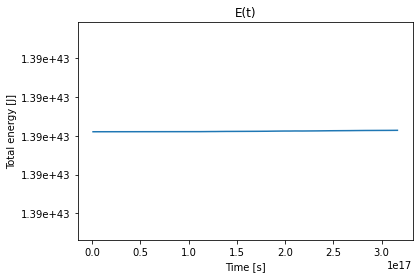

In [7]:
plt.gca().yaxis.set_major_formatter(FuncFormatter(custom_formatter))  #Makes y axis numbers look prettier

plt.title('E(t)')
plt.xlabel('Time [s]')
plt.ylabel('Total energy [J]')
plt.plot(TIME,E)
plt.show()

In [8]:
#We can see that the energy is conserved, even over ~Gyr periods, which is good.

#Next, we can take a look at the potential and kinetic energies individually

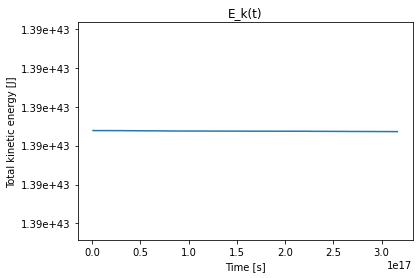

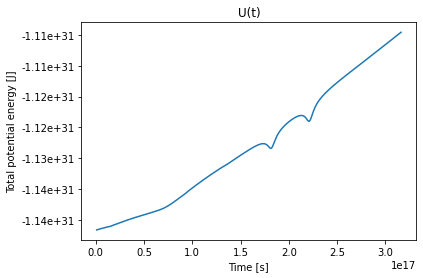

In [9]:
plt.gca().yaxis.set_major_formatter(FuncFormatter(custom_formatter)) 

plt.title('E_k(t)')
plt.xlabel('Time [s]')
plt.ylabel('Total kinetic energy [J]')
plt.plot(TIME,K)
plt.show()

plt.clf()

plt.gca().yaxis.set_major_formatter(FuncFormatter(custom_formatter))  

plt.title('U(t)')
plt.xlabel('Time [s]')
plt.ylabel('Total potential energy [J]')
plt.plot(TIME,U)
plt.show()

In [10]:
"""
Here we see some important information. Firstly, the kinetic energy is more stable than the potential energy.
It might seem like kinetic energy is the exact same value over all time, but if you print its value during each time step in the main cell,
you will see that's not the case. It's just that the change is too small to be visible on the graph. On the other hand, the potential energy
is less stable, which is actually expected.

The reason for that is that the kinetic energy scales with the velocity (~v^2), whereas the potential energy scales primarily with position
(~1/r). During the evolution of this galaxy, we expect its constituents to move around at all times, drastically changing their positions
over time. On the other hand, most of its particles should be in relatively stable rotation around the center of mass, leading to very
small changes in velocity over time. Even so, during the ~10Gyr simulation time, the total potential energy never changed more than a few
percent, which, for a toy model galaxy with just 400 particles, is a good result.
"""

"\nHere we see some important information. Firstly, the kinetic energy is more stable than the potential energy.\nIt might seem like kinetic energy is the exact same value over all time, but if you print its value during each time step in the main cell,\nyou will see that's not the case. It's just that the change is too small to be visible on the graph. On the other hand, the potential energy\nis less stable, which is actually expected.\n\nThe reason for that is that the kinetic energy scales with the velocity (~v^2), whereas the potential energy scales primarily with position\n(~1/r). During the evolution of this galaxy, we expect its constituents to move around at all times, drastically changing their positions\nover time. On the other hand, most of its particles should be in relatively stable rotation around the center of mass, leading to very\nsmall changes in velocity over time. Even so, during the ~10Gyr simulation time, the total potential energy never changed more than a few\np

In [11]:
"""
Now, we might want to look closer into the morphology of this galaxy. For starters, we could try something like a 3D plot of
all particles' positions
"""

"\nNow, we might want to look closer into the morphology of this galaxy. For starters, we could try something like a 3D plot of\nall particles' positions\n"

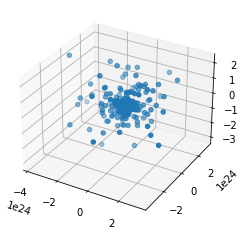

In [12]:
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter3D(X, Y, Z)
plt.show()

In [13]:
"""
This gives us a general glimpse into how this galaxy looks like, but it gives us no quantifiable data. For this purpose, we want to
analyze a density plot. For this, we first need to find the center of mass, move our coordinate system so its origin is the center of mass,
and then calculate the density of concentric thin shells around the center of mass, with increasing radius.
"""

'\nThis gives us a general glimpse into how this galaxy looks like, but it gives us no quantifiable data. For this purpose, we want to\nanalyze a density plot. For this, we first need to find the center of mass, move our coordinate system so its origin is the center of mass,\nand then calculate the density of concentric thin shells around the center of mass, with increasing radius.\n'

5334708576583680.0 -7311592574025728.0 -4.354195091514982e+16


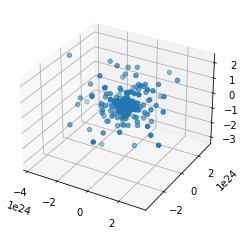

In [14]:
comx = 0 #Initialize center of mass
comy = 0
comz = 0

#Total mass of the system calculation
M = 0
for i in range(N):
    M+=BODIES[i].m

for i in range(N):
    comx += BODIES[i].x*BODIES[i].m/M
    comy += BODIES[i].y*BODIES[i].m/M
    comz += BODIES[i].z*BODIES[i].m/M


#Let's see where the center of mass is on the upper plot
print(comx, comy, comz)

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter3D(X, Y, Z)
ax.scatter3D(comx, comy,comz, color='red')
plt.show()

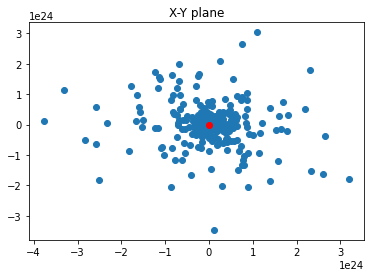

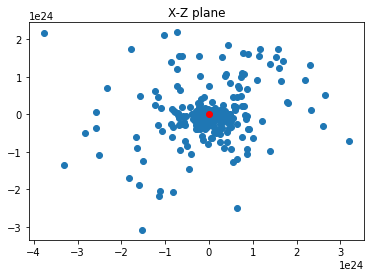

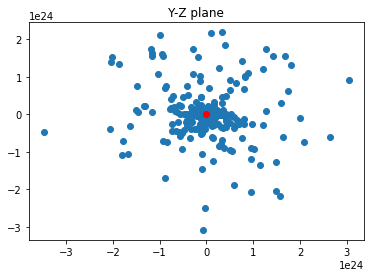

In [15]:
#As we can see from the plot and the printed coordinates, the COM is somewhere near the main cluster of particles, as expected.
#Let's see in more detail on 2D plots

plt.title('X-Y plane')
plt.scatter(X,Y)
plt.scatter(comx,comy, color='red')
plt.show()

plt.title('X-Z plane')
plt.scatter(X,Z)
plt.scatter(comx,comz, color='red')
plt.show()

plt.title('Y-Z plane')
plt.scatter(Y,Z)
plt.scatter(comy,comz, color='red')
plt.show()

In [16]:
#Everything seems to be in order, so we can move on to building the density profile
#We first move the entire system so that the center of mass is in the r=0 point

for i in range(N):
    BODIES[i].x -= comx
    BODIES[i].y -= comy
    BODIES[i].z -= comz



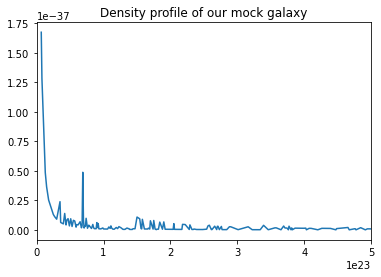

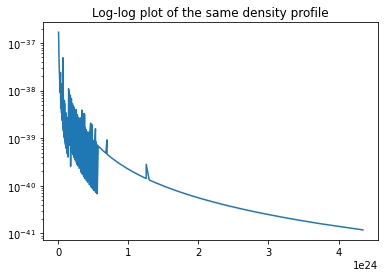

In [34]:
RADII = []
DENSITIES = []

r = 1e8
dr = 1e21

#Go in expanding concentric spherical shells around the center of mass
while r<5e24:

    #Calculate total mass within given shell
    mass = 0
    for i in range(N):
        #If a particle is within [r, r+dr]
        if distance(BODIES[i].x, 0, BODIES[i].y, 0, BODIES[i].z, 0)<= r+dr and distance(BODIES[i].x, 0, BODIES[i].y, 0, BODIES[i].z, 0)> r:
            mass+=BODIES[i].m

    volume = 4*3.1415*r*r*dr #Volume of given shell
    density = mass/volume #Density within [r, r+dr]
    if mass != 0:
        RADII.append(r)
        DENSITIES.append(density)

    r+=dr


plt.title('Density profile of our mock galaxy')
plt.plot(RADII, DENSITIES)
plt.xlim(0, 5e23)
plt.show()

plt.clf()

plt.title('Logarithmic plot of the same density profile')
plt.plot(RADII, DENSITIES)
plt.yscale('log')
plt.show()    

In [ ]:
"""
The 'coarsness' of these plots is due to the low number of bodies in our test galaxy. Many of the shells that we iterated over had
no particles in them at all. I have removed those dots from the plots for clarity, but this means that we can't have smooth graphs.

In order to create a galaxy with a smooth density plot, we'd need to have upwards of 500 thousand particles in it, which isn't practical
for the purposes of this excercise.

As a final touch before we wrap up, we can generate a heatmap of our galaxy. Since there's a small amount of particles in it, the
resolution won't be very satisfying. However, it's still good practice, as heatmaps can often provide insightful information about the
structure of a galaxy, or even the possible formation of substructures within it (shells, streams, globular clusters etc).
"""

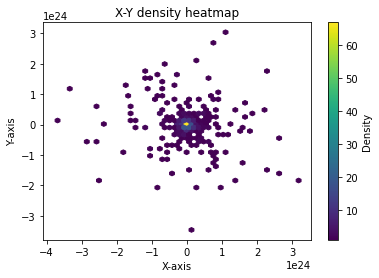

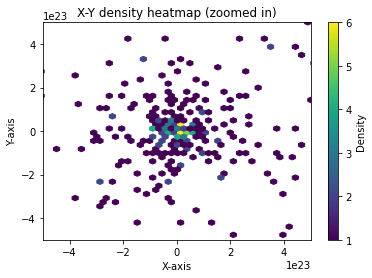

In [54]:
plt.hexbin(X, Y, gridsize=50, cmap='viridis', mincnt=1)
plt.colorbar(label='Density')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('X-Y density heatmap')
plt.show()

plt.clf()

plt.hexbin(X, Y, gridsize=300, cmap='viridis', mincnt=1)
plt.colorbar(label='Density')
plt.xlabel('X-axis')
plt.xlim(-5e23, 5e23)
plt.ylim(-5e23, 5e23)
plt.ylabel('Y-axis')
plt.title('X-Y density heatmap (zoomed in)')
plt.show()